In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt


In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False, surrendered=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False, surrendered=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False, surrendered=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False, surrendered=False),
 True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False, surrendered=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False, surrendered=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False, surrendered=False),
 True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[1, 7, 1, 9, 12, 9, 9, 4, 10, 13]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h16, cards=[6, 12], doubled=False, drawn=False, surrendered=False),
  Hand(score=h20, cards=[11, 10], doubled=False, drawn=False, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h16, cards=[6, 12], doubled=False, drawn=False, surrendered=False),
  Hand(score=h20, cards=[11, 10], doubled=False, drawn=False, surrendered=False),
  <HandOutcome.LOSE: -1>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [2, 8],
  'dealer_card': 1,
  'hand_end': [2, 8, 12],
  'dealer_hand': [1, 10],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer',
  'hand_start': [2, 8],
  'dealer_card': 1,
  'hand_end': [2, 8, 10],
  'dealer_hand': [1, 10],
  'outcome': <HandOutcome.LOSE: -1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card     hand_end       dealer_hand  \
 0   simple     [2, 5]            2   [2, 5, 11]      [2, 7, 6, 5]   
 1   simple     [4, 6]            4    [4, 6, 3]        [4, 11, 8]   
 2   simple     [3, 7]            8   [3, 7, 12]           [8, 10]   
 3   simple    [6, 10]            2  [6, 10, 13]  [2, 4, 4, 3, 12]   
 4   simple    [12, 3]           10   [12, 3, 6]       [10, 3, 13]   
 5   simple    [9, 12]           12      [9, 12]          [12, 11]   
 6   simple   [11, 11]            5     [11, 11]         [5, 3, 9]   
 7   simple    [8, 10]            4      [8, 10]        [4, 8, 12]   
 8   simple    [12, 8]            8      [12, 8]           [8, 13]   
 9   simple   [11, 10]            3     [11, 10]      [3, 4, 3, 8]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1   HandOutcome.WIN            1.0          WIN  
 2   HandOutcome.WIN            1.0          WIN  
 3  HandOutcome.LOSE    

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, Action)
strats

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.SURRENDER: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=True),
  Hand(score=h20, cards=[2, 6, 2, 11], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.SURRENDER: -0.5>),
 ('<Action.STAND: 2>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False, surrendered=False),
  Hand(score=h20, cards=[2, 6, 2, 11], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.HIT: 3>',
  Hand(score=h22, cards=[5, 7, 12], doubled=False, drawn=True, surrendered=False),
  Hand(score=h20, cards=[2, 6, 2, 11], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 4>',
  Hand(score=h22, cards=[5, 7, 13], doubled=True, drawn=True, surrendered=False),
  Hand(score=h20, cards=[2, 6, 2, 11], doubled=False, drawn=True, surrendered=False),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        6050  454         0     0       3496   
<Action.HIT: 3>        6076           0  668         0  3256          0   
<Action.STAND: 2>      6382           0    0         0  3618          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.5108  
<Action.HIT: 3>            -0.2820  
<Action.STAND: 2>          -0.2764  
<Action.SURRENDER: 1>      -0.5000

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False, surrendered=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False, surrendered=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, Action)
strats

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        6326    0         0     0       3674   
<Action.HIT: 3>        5332           0  771         0  3897          0   
<Action.STAND: 2>      6326           0    0         0  3674          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
simple                 5107           0  820         0  4073          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.5304  
<Action.HIT: 3>            -0.1435  
<Action.STAND: 2>          -0.2652  
<Action.SURRENDER: 1>      -0.5000  
simple                     -0.1034

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6088  674  3238      -0.2850
strat_cond    6311    0  3689      -0.2622

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, Action)
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        5817    0         0     0       4183   
<Action.HIT: 3>        4901           0  308         0  4791          0   
<Action.STAND: 2>      5817           0    0         0  4183          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
simple                 5817           0    0         0  4183          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>         -0.3268  
<Action.HIT: 3>            -0.0110  
<Action.STAND: 2>          -0.1634  
<Action.SURRENDER: 1>      -0.5000  
simple                     -0.1634

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, Action)
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                              \
outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
strategy                                                                  
<Action.DOUBLE: 4>        0        3237  709         0     0       6054   
<Action.HIT: 3>        3179           0  683         0  6138          0   
<Action.STAND: 2>      5807           0    0         0  4193          0   
<Action.SURRENDER: 1>     0           0    0     10000     0          0   
simple                 3295           0  658         0  6047          0   

                      mean_outcome  
outcome_name                        
strategy                            
<Action.DOUBLE: 4>          0.5634  
<Action.HIT: 3>             0.2959  
<Action.STAND: 2>          -0.1614  
<Action.SURRENDER: 1>      -0.5000  
simple                      0.2752

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                         len                                              \
 outcome_name           LOSE LOSE_DOUBLE PUSH SURRENDER   WIN WIN_DOUBLE   
 strategy                                                                  
 <Action.DOUBLE: 4>        0        3193  671         0     0       6136   
 <Action.HIT: 3>        3177           0  670         0  6153          0   
 <Action.STAND: 2>      5728           0    0         0  4272          0   
 <Action.SURRENDER: 1>     0           0    0     10000     0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          0.5886  
 <Action.HIT: 3>             0.2976  
 <Action.STAND: 2>          -0.1456  
 <Action.SURRENDER: 1>      -0.5000  )

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0         145    6         0    0         49   
 <Action.HIT: 3>        150           0    7         0   43          0   
 <Action.STAND: 2>       58           0   15         0  127          0   
 <Action.SURRENDER: 1>    0           0    0       200    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>          -0.960  
 <Action.HIT: 3>             -0.535  
 <Action.STAND: 2>            0.345  
 <Action.SURRENDER: 1>       -0.500  )

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0          65   12         0    0        123   
 <Action.HIT: 3>         69           0   16         0  115          0   
 <Action.STAND: 2>        0           0   20         0  180          0   
 <Action.SURRENDER: 1>    0           0    0       200    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>            0.58  
 <Action.HIT: 3>               0.23  
 <Action.STAND: 2>             0.90  
 <Action.SURRENDER: 1>        -0.50  )

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 4>': 0.62,
 '<Action.HIT: 3>': 0.31,
 '<Action.STAND: 2>': -0.24,
 '<Action.SURRENDER: 1>': -0.5,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 4>,
 'winning_act_outcome': 0.62}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                        len                                             \
 outcome_name          LOSE LOSE_DOUBLE PUSH SURRENDER  WIN WIN_DOUBLE   
 strategy                                                                
 <Action.DOUBLE: 4>       0         867   24         0    0        109   
 <Action.HIT: 3>        866           0   30         0  104          0   
 <Action.STAND: 2>      608           0  119         0  273          0   
 <Action.SURRENDER: 1>  303           0    0       697    0          0   
 
                       mean_outcome  
 outcome_name                        
 strategy                            
 <Action.DOUBLE: 4>         -1.5160  
 <Action.HIT: 3>            -0.7620  
 <Action.STAND: 2>          -0.3350  
 <Action.SURRENDER: 1>      -0.6515  )

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 4>  <Action.HIT: 3>  <Action.STAND: 2>  \
score_p score_d                                                           
h09     s11                    -0.6           -0.325               -0.9   
        h02                    -0.1            0.150               -0.5   
        h03                    -0.3           -0.025               -0.5   
        h04                     0.6            0.225                0.0   
        h05                    -0.3           -0.250               -0.6   
...                             ...              ...                ...   
s21     h06                     0.5            0.100                0.9   
        h07                     0.6            0.075                0.9   
        h08                     0.2            0.100                1.0   
        h09                     0.0           -0.100                0.8   
        h10                     0.5            0.250                1.0   

                 <Action.SURRENDER: 1>    winning_act  winning_act_outcome  
score_p score_d                                                             
h09     s11                     -0.625     Action.HIT               -0.325  
        h02                     -0.500     Action.HIT                0.150  
        h03                     -0.500     Action.HIT               -0.025  
        h04                     -0.500  Action.DOUBLE                0.600  
        h05                     -0.500     Action.HIT               -0.250  
...                                ...            ...                  ...  
s21     h06                     -0.500   Action.STAND                0.900  
        h07                     -0.500   Action.STAND                0.900  
        h08                     -0.500   Action.STAND                1.000  
        h09                     -0.500   Action.STAND                0.800  
        h10                     -0.500   Action.STAND                1.000  

[250 rows x 6 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

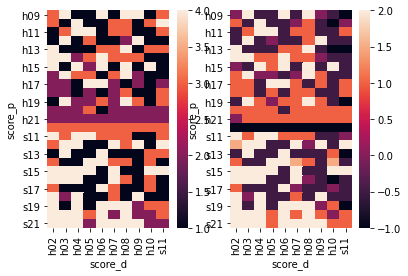

In [41]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(   strategy hand_start  dealer_card       hand_end   dealer_hand  \
 0    simple     [2, 6]            2   [2, 6, 7, 2]   [2, 10, 11]   
 1  memoized     [2, 6]            2  [2, 6, 5, 13]   [2, 10, 11]   
 2    simple     [6, 8]           10      [6, 8, 4]       [10, 1]   
 3  memoized     [6, 8]           10      [6, 8, 3]       [10, 1]   
 4    simple     [9, 2]            3     [9, 2, 10]   [3, 13, 12]   
 5  memoized     [9, 2]            3      [9, 2, 3]   [3, 13, 12]   
 6    simple    [3, 10]            1     [3, 10, 6]  [1, 5, 4, 1]   
 7  memoized    [3, 10]            1  [3, 10, 1, 3]  [1, 5, 4, 1]   
 8    simple    [10, 6]            7     [10, 6, 7]       [7, 10]   
 9  memoized    [10, 6]            7     [10, 6, 1]       [7, 10]   
 
                   outcome  outcome_value outcome_name  
 0         HandOutcome.WIN            1.0          WIN  
 1        HandOutcome.LOSE           -1.0         LOSE  
 2        HandOutcome.LOSE           -1.0         LOSE  
 3        H

Starting iteration 0
Starting iteration 1
('h09', 'h02') Action.DOUBLE Action.HIT
('h09', 'h04') Action.HIT Action.DOUBLE
('h09', 'h07') Action.HIT Action.DOUBLE
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 'h08') Action.DOUBLE Action.HIT
('h11', 'h10') Action.HIT Action.DOUBLE
('h12', 'h05') Action.HIT Action.STAND
('h12', 'h06') Action.HIT Action.STAND
('h13', 's11') Action.SURRENDER Action.HIT
('h13', 'h03') Action.STAND Action.HIT
('h13', 'h05') Action.STAND Action.DOUBLE
('h13', 'h06') Action.HIT Action.STAND
('h14', 's11') Action.HIT Action.STAND
('h14', 'h03') Action.STAND Action.HIT
('h14', 'h10') Action.HIT Action.SURRENDER
('h15', 's11') Action.SURRENDER Action.HIT
('h15', 'h04') Action.STAND Action.HIT
('h15', 'h07') Action.HIT Action.STAND
('h15', 'h08') Action.HIT Action.STAND
('h16', 'h02') Action.STAND Action.HIT
('h16', 'h08') Action.HIT Action.SURRENDER
('h16', 'h10') Action.HIT Action.STAND
('s11', 'h07') Action.HIT Action.DOUBLE
('s11', 'h08') Action.HIT Action.DO

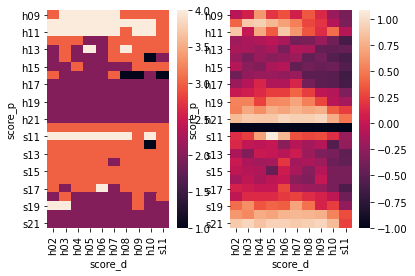

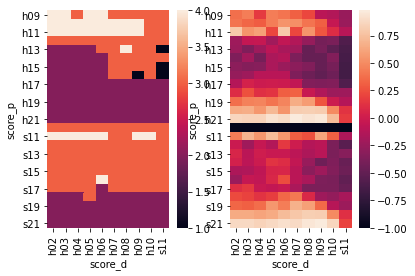

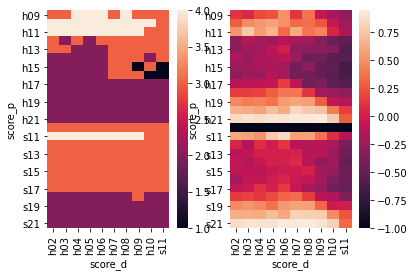

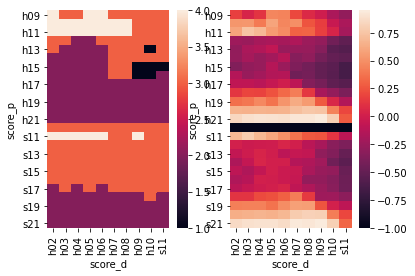

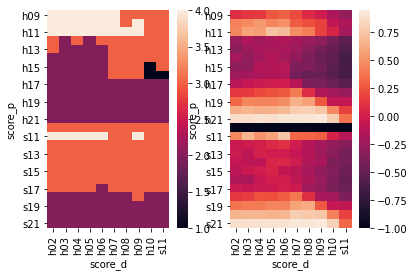

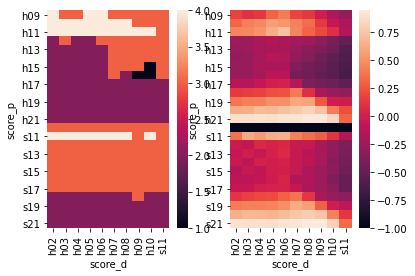

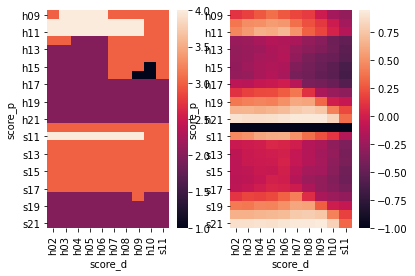

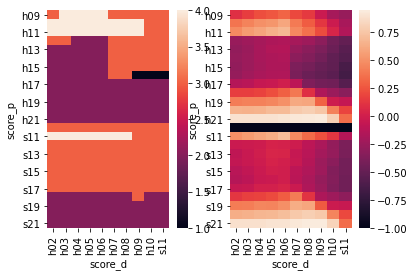

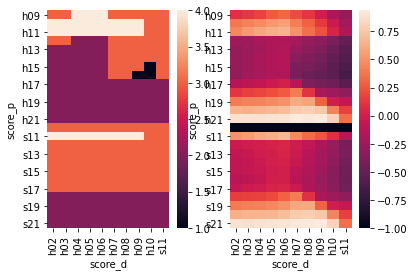

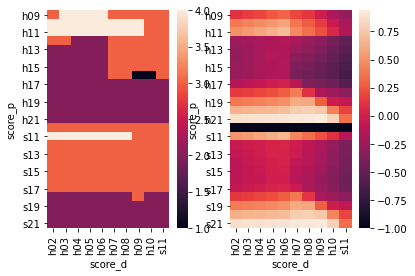

In [43]:


strategies = opt.derive_iterative_strategies(strat_simple, 10)
strategies

In [44]:
with open('strategies.pickle', 'wb') as handle:
    pickle.dump(strategies, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card        hand_end dealer_hand  \
 0   simple    [13, 2]            1   [13, 2, 4, 6]     [1, 13]   
 1  iter(1)    [13, 2]            1      [13, 2, 9]     [1, 13]   
 2  iter(2)    [13, 2]            1      [13, 2, 4]     [1, 13]   
 3  iter(3)    [13, 2]            1      [13, 2, 3]     [1, 13]   
 4  iter(4)    [13, 2]            1      [13, 2, 3]     [1, 13]   
 5  iter(5)    [13, 2]            1      [13, 2, 6]     [1, 13]   
 6  iter(6)    [13, 2]            1      [13, 2, 5]     [1, 13]   
 7  iter(7)    [13, 2]            1   [13, 2, 4, 4]     [1, 13]   
 8  iter(8)    [13, 2]            1      [13, 2, 5]     [1, 13]   
 9  iter(9)    [13, 2]            1  [13, 2, 1, 10]     [1, 13]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1  HandOutcome.LOSE           -1.0         LOSE  
 2  HandOutcome.LOSE           -1.0         LOSE  
 3  HandOutcome.LOSE           -1.0         LOSE  
 4  Ha